# Reference
* starter code
  * https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
  * https://www.kaggle.com/philculliton/nlp-getting-started-tutorial
* Text preprocessing
  * https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/

# Libraries

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd 
import string
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.5) 

%matplotlib inline


from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


* check sample data

In [5]:
import copy
tmp = copy.deepcopy(train_df)
tmp = tmp.dropna()
tmp

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [6]:
tmp.loc[tmp['target']==1, 'text'].values[1]

'#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi'

In [7]:
tmp.loc[tmp['target']==0, 'text'].values[1]

'Crying out for more! Set me ablaze'

# Simple EDA

* target distribution

Text(0.5, 1.0, 'Count plot - target')

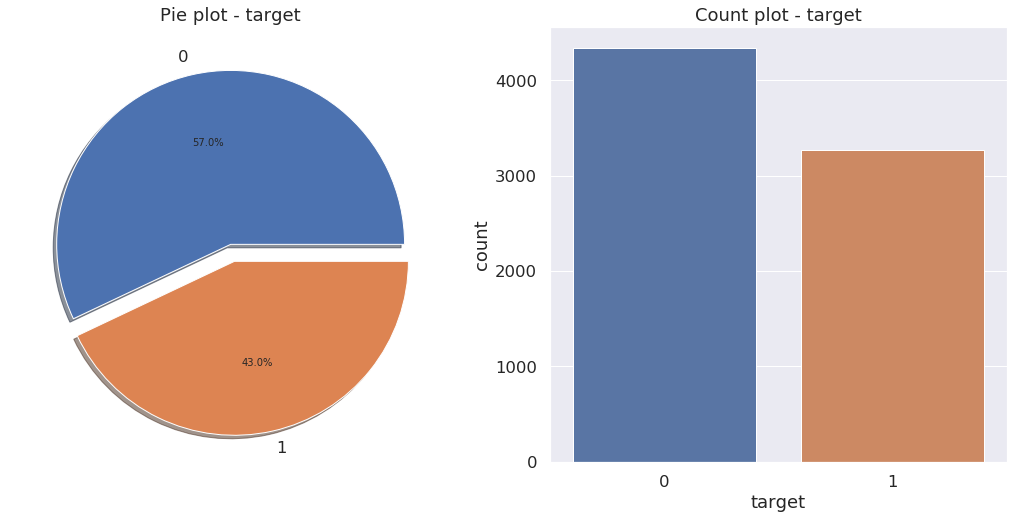

In [8]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

train_df['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - target')
ax[0].set_ylabel('')

sns.countplot('target', data=train_df, ax=ax[1])
ax[1].set_title('Count plot - target')


* id, keyword, location

In [9]:
len(train_df['id'].unique()), len(train_df)

(7613, 7613)

In [10]:
print('null check')
train_df.isnull().sum()

null check


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
print('keyword unique val', len(train_df['keyword'].unique()))
train_df['keyword'].unique()

keyword unique val 222


array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [12]:
print('location unique val', len(train_df['location'].unique()))
train_df['location'].unique()

location unique val 3342


array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

* keyword, location 값의 존재 유무와 target 간의 상관 관계?

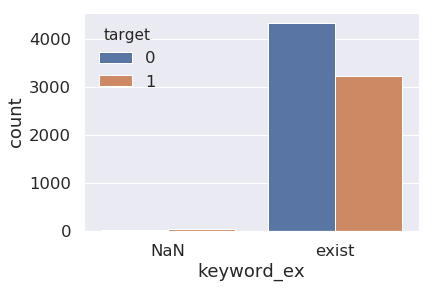

In [13]:
tmp2 = copy.deepcopy(train_df)
# tmp2['target'] = tmp2['target'].astype(str)
tmp2['keyword_ex'] = 'exist'
tmp2['keyword_ex'].iloc[np.where(tmp2['keyword'].isnull() == True)] = 'NaN'
sns.countplot(x='keyword_ex',hue='target', data = tmp2)

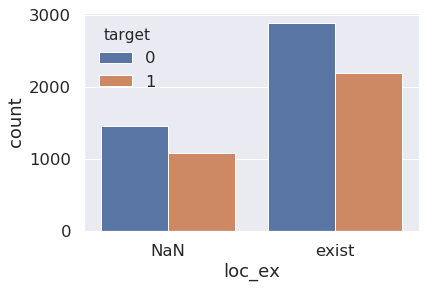

In [14]:
tmp2['loc_ex'] = 'exist'
tmp2['loc_ex'].iloc[np.where(tmp2['location'].isnull() == True)] = 'NaN'
sns.countplot(x='loc_ex',hue='target', data = tmp2)

* tweet length distribution

Text(0.5, 1.0, 'tweet length plot - target 1')

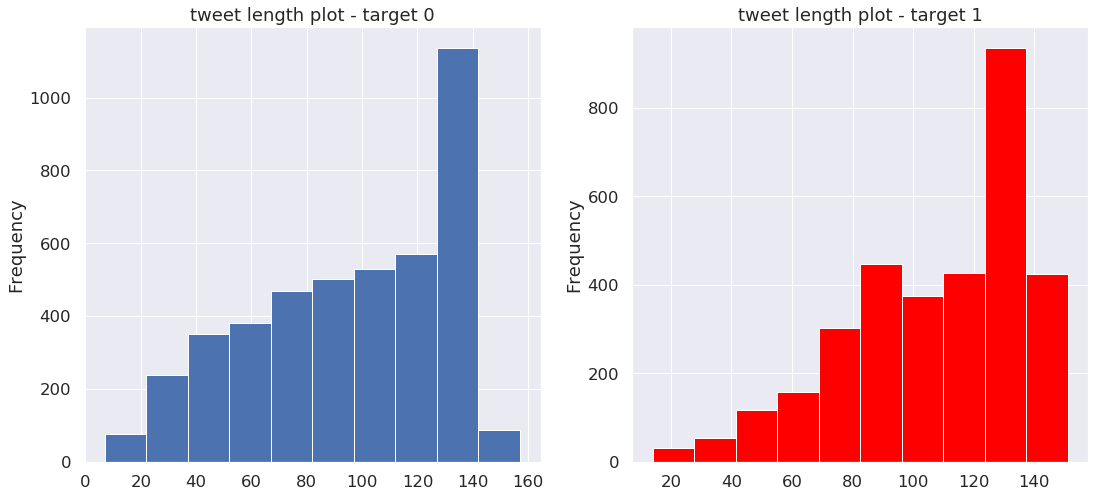

In [15]:
tmp2['twt_length'] = tmp2['text'].agg(lambda x: len(x))

_, ax = plt.subplots(1, 2, figsize=(18, 8))

tmp2.loc[tmp2['target']==0, 'twt_length'].plot(kind='hist', ax=ax[0])
ax[0].set_title('tweet length plot - target 0')

tmp2.loc[tmp2['target']==1, 'twt_length'].plot(kind='hist', ax=ax[1], color='red')
ax[1].set_title('tweet length plot - target 1')

* word num distribution

Text(0.5, 1.0, 'word count plot - target 1')

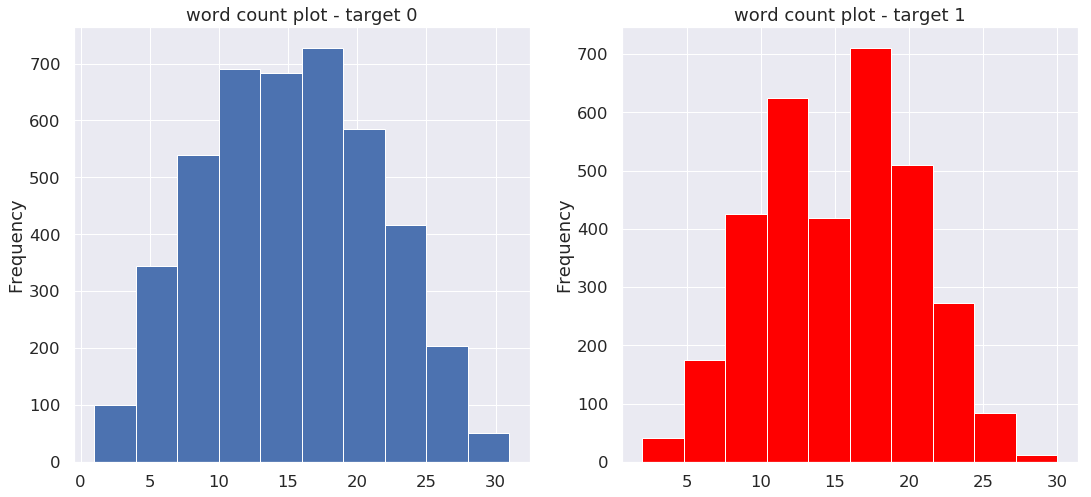

In [16]:
tmp2['word_cnt'] = tmp2['text'].agg(lambda x: len(x.strip().split()))

_, ax = plt.subplots(1, 2, figsize=(18, 8))

tmp2.loc[tmp2['target']==0, 'word_cnt'].plot(kind='hist', ax=ax[0])
ax[0].set_title('word count plot - target 0')

tmp2.loc[tmp2['target']==1, 'word_cnt'].plot(kind='hist', ax=ax[1], color='red')
ax[1].set_title('word count plot - target 1')

* n-gram analysis

In [17]:
# bi-gram analysis
corpus = train_df['text']
# 문서 토큰화, bi-gram으로.
vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # ngram_range : (min_n, max_n) 

# vec.vocabulary_ # 단어장. dictionary

bag_of_words = vec.transform(corpus) # bow, 각 문서 내 토큰 빈도수(bi-gram 빈도수)
sum_words = bag_of_words.sum(axis=0) # 각 토큰들의 전체 빈도수
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # (토큰, 빈도수)
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print('bi-gram count top 10', words_freq[:10], sep='\n')

bi-gram count top 10
[('http co', 4306), ('https co', 410), ('in the', 308), ('of the', 256), ('û_ http', 217), ('on the', 129), ('to the', 126), ('to be', 108), ('for the', 97), ('at the', 85)]


Text(0.5, 1.0, 'bi-gram count top 10')

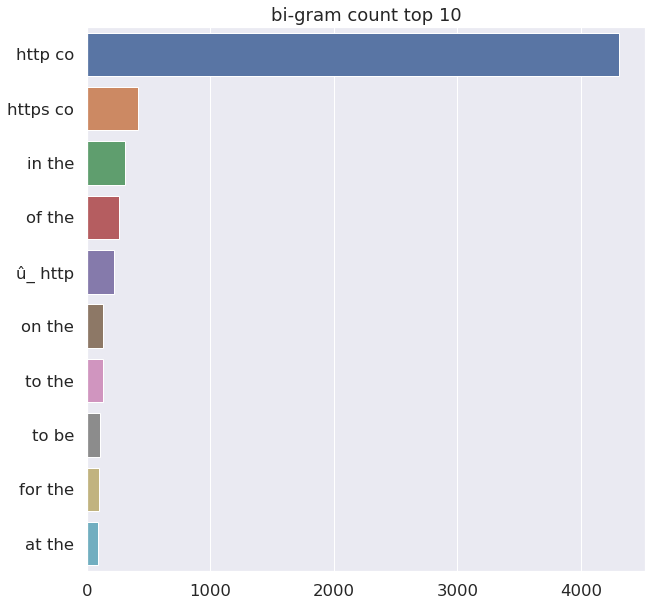

In [18]:
bigram, freq = map(list, zip(*words_freq[:10]))

_, ax = plt.subplots(1,1,figsize=(10,10))
sns.barplot(y=bigram, x=freq, ax=ax)
ax.set_title('bi-gram count top 10')

In [19]:
def get_bigram_top10(corpus):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)  
    bag_of_words = vec.transform(corpus) 
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:10]

Text(0.5, 1.0, 'bi-gram count(remove stop word) top 10 in target 1')

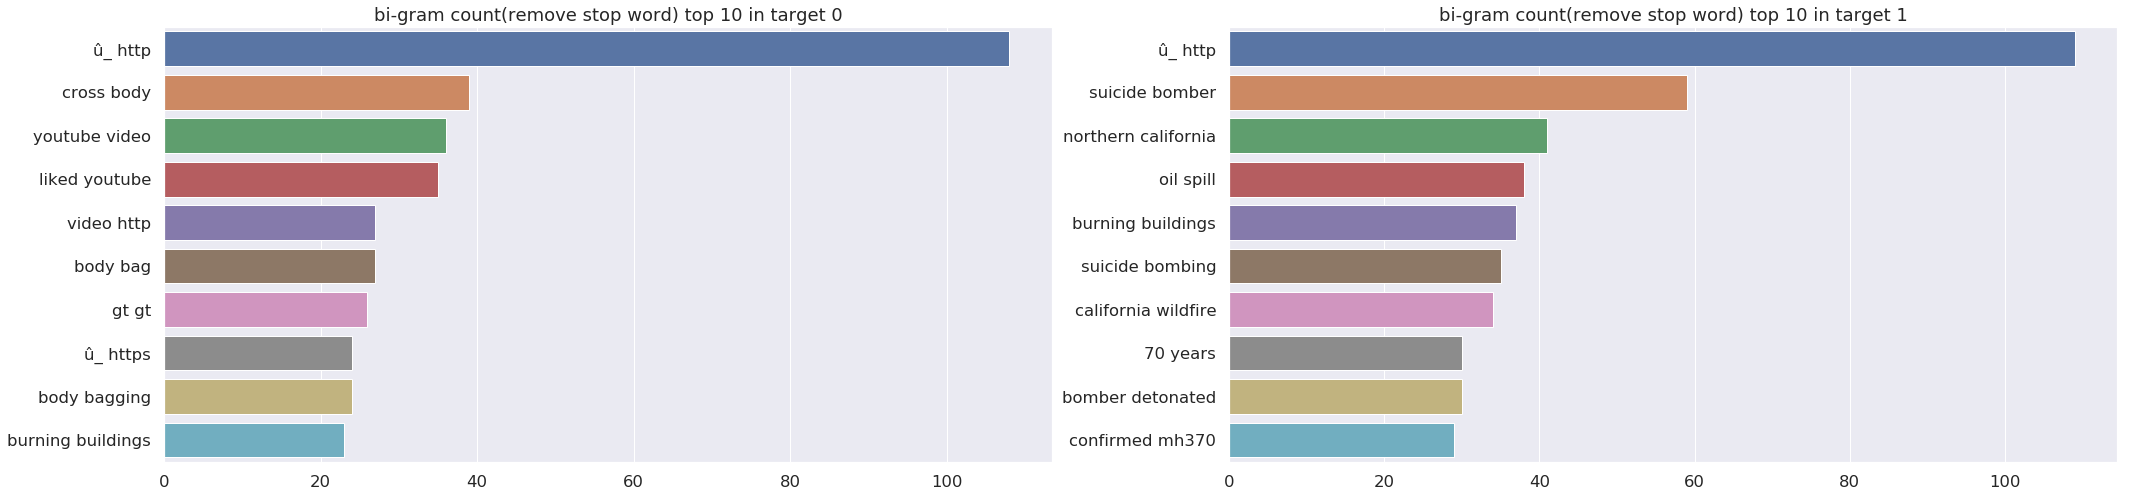

In [20]:
_, ax = plt.subplots(1,2,figsize=(35,8))

bigram, freq = map(list, zip(*get_bigram_top10(train_df.loc[train_df['target']==0, 'text'])))
sns.barplot(y=bigram, x=freq, ax=ax[0])
ax[0].set_title('bi-gram count(remove stop word) top 10 in target 0')

bigram, freq = map(list, zip(*get_bigram_top10(train_df.loc[train_df['target']==1, 'text'])))
sns.barplot(y=bigram, x=freq, ax=ax[1])
ax[1].set_title('bi-gram count(remove stop word) top 10 in target 1')

1. not disaster tweet 상위 랭크에 'youtube'
2. 손코딩으로 전처리 작업 필요

# Data cleansing
### remove stop words(불용어)

In [21]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [22]:
all_df = pd.concat((train_df.iloc[:,:-1], test_df))
all_df.reset_index(drop=True, inplace=True)
all_df.tail()

,id,keyword,location,text
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


* url check

        < re 문법 >
        .
        문자 1개

        []
        [abc]d는 ad, bd, cd를 뜻한다. 또한, "-" 기호와 함께 쓰면 범위를 지정할 수 있다. "[a-z]"는 a부터 z까지 중 하나, "[1-9]"는 1부터 9까지 중의 하나를 의미한다.

        [^]
        [^abc]d는 ad, bd, cd는 포함하지 않고 ed, fd 등을 포함한다. [^a-z]는 알파벳 소문자로 시작하지 않는 모든 문자를 의미한다.

        ?
        포함하거나 안하거나,
        colou?r는 "color"와 "colour"를 둘 다 일치시킨다.

        *
        0번 이상,
        ab*c는 "ac", "abc", "abbc", "abbbc" 등을 일치시킨다.

        +
        1번 이상,
        ab+c는 "abc", "abbc", "abbbc" 등을 일치시키지만 "ac"는 일치시키지 않는다.

        \s 
        스페이스, 공백
        
        \S
        공백 제외 모든 문자


In [23]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

all_df['text'].values[100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [24]:
all_df['text']=all_df['text'].apply(lambda x : remove_URL(x))
all_df['text'].values[100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion '

* html tag check

In [25]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

np.where(all_df['text'].apply(lambda x: bool(re.search(r'<.*?>', x))) == True)

(array([], dtype=int64),)

there are no html tag

In [26]:
all_df['text']=all_df['text'].apply(lambda x : remove_html(x))

* emoji check

In [27]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

np.where(all_df['text'].apply(lambda x: bool(re.search("["
                                                       u"\U0001F600-\U0001F64F"  # emoticons
                                                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                       u"\U00002702-\U000027B0"
                                                       u"\U000024C2-\U0001F251"
                                                       "]+", x, flags=re.UNICODE))) == True)

(array([], dtype=int64),)

there are no emoji

In [28]:
all_df['text']=all_df['text'].apply(lambda x : remove_emoji(x))

* punctuations check

In [29]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation) # python punctuation 제거 메소드
    return text.translate(table)
all_df['text'].values[100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion '

In [30]:
all_df['text']=all_df['text'].apply(lambda x : remove_punct(x))
all_df['text'].values[100]

'NorwayMFA Bahrain police had previously died in a road accident they were not killed by explosion '

* spelling check
  * using python 'pyspellcheker' library
  * this process require time consuming,

In [31]:
# !pip install pyspellchecker

In [32]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())  # 문장에서 스펠링이 틀린 단어를 찾는다.
#     for word in text.split():
#         if word in misspelled_words: # 해당 단어의 스펠링이 틀렸으면,
#             corrected_text.append(spell.correction(word)) # 고친다.
#         else:
#             corrected_text.append(word) # 아니면 패스
#     return " ".join(corrected_text) # 교정한 단어와 다른 단어들을 합친다.

# # all_df['text'].values[100]

In [33]:
# all_df['text']=all_df['text'].apply(lambda x : correct_spellings(x))
# all_df['text'].values[100]

# Modeling

* tokenize, train/val data split

In [34]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        # 불용어 제거, 모든 문자 소문자로 변환.
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [35]:
corpus=create_corpus(all_df)

100%|██████████| 10876/10876 [00:02<00:00, 4080.23it/s]


In [36]:
MAX_LEN=50 # 문장 최대 길이 50

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [37]:
train=tweet_pad[:len(train_df)]
test=tweet_pad[len(train_df):]

In [38]:
X_train,X_val,y_train,y_val=train_test_split(train,train_df['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


* pre-train embedding matrix

In [39]:
# embedding vocabulary 준비
glove_dir = '../input/glove-global-vectors-for-word-representation/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8") # 100차원 임베딩 벡터 파일
# .txt 파일 파싱
for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs # 단어와 이에 상응하는 벡터 표현(숫자 벡터)를 매핑하는 인덱스 생성.
f.close()

In [40]:
# embedding matrix 준비

num_words=len(word_index)+1 # token num
embedding_dim = 100 # embedding 차원

embedding_matrix=np.zeros((num_words,embedding_dim))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embeddings_index.get(word) # 각 토큰에 해당하는 벡터 가져옴.
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 309226.47it/s]


* keras f1_score

In [41]:
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

* modeling

In [42]:
model=Sequential()

embedding=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=[f1score])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


* learning

In [43]:
history=model.fit(X_train,y_train,
                  batch_size=4,
                  epochs=15,
                  validation_data=(X_val,y_val),
                  verbose=2)

model.save_weights('model.h5')

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 87s - loss: 0.6917 - f1score: 0.0077 - val_loss: 0.6895 - val_f1score: 0.0000e+00
Epoch 2/15
 - 86s - loss: 0.6787 - f1score: 0.0242 - val_loss: 0.6234 - val_f1score: 0.1450
Epoch 3/15
 - 84s - loss: 0.6138 - f1score: 0.4089 - val_loss: 0.5386 - val_f1score: 0.5825
Epoch 4/15
 - 84s - loss: 0.5823 - f1score: 0.5560 - val_loss: 0.5220 - val_f1score: 0.5942
Epoch 5/15
 - 85s - loss: 0.5648 - f1score: 0.5628 - val_loss: 0.5126 - val_f1score: 0.5950
Epoch 6/15
 - 83s - loss: 0.5585 - f1score: 0.5696 - val_loss: 0.5086 - val_f1score: 0.6060
Epoch 7/15
 - 83s - loss: 0.5607 - f1score: 0.5600 - val_loss: 0.5063 - val_f1score: 0.6067
Epoch 8/15
 - 81s - loss: 0.5501 - f1score: 0.5661 - val_loss: 0.5029 - val_f1score: 0.5920
Epoch 9/15
 - 82s - loss: 0.5497 - f1score: 0.5647 - val_loss: 0.5008 - val_f1score: 0.5939
Epoch 10/15
 - 82s - loss: 0.5502 - f1score: 0.5528 - val_loss: 0.4989 - val_f1score: 0.6098
Epoch 11/15
 - 81s - loss: 

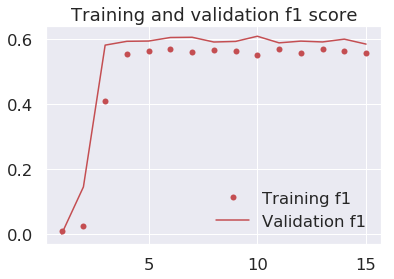

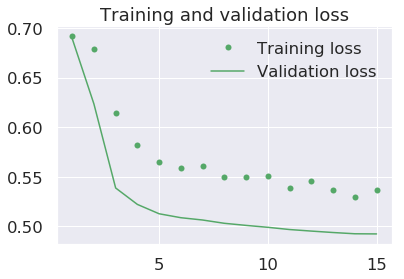

In [44]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
fl = history.history['f1score']
val_fl = history.history['val_f1score']

epochs = range(1, len(fl) + 1)

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

plt.plot(epochs, fl, 'ro', label='Training f1')
plt.plot(epochs, val_fl, 'r', label='Validation f1')
plt.title('Training and validation f1 score')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Prediction & Submission

In [45]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [46]:
model.load_weights('model.h5')
y_pred = model.predict(test)
y_pred = np.round(y_pred).astype(int).reshape(-1,)
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),
                    'target':y_pred})
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [47]:
sub.to_csv('submission.csv',index=False)